In [1]:
import os
from collections import Counter

# Data Handling and Processing
import numpy as np
import pandas as pd
from PIL import Image

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn Modules
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

# Torchvision
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import vgg19, VGG19_Weights

# Progress Monitoring
from tqdm import tqdm


In [2]:
org_df = pd.read_csv("/kaggle/input/meld-dataset/MELD-RAW/MELD.Raw/train/train_sent_emo.csv")
org_df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


In [3]:
%%capture

! pip install facenet-pytorch

In [4]:
from facenet_pytorch import MTCNN

def filter_df_with_existing_faces(df, img_dir, device='cuda' if torch.cuda.is_available() else 'cpu'):
    mtcnn = MTCNN(keep_all=False, device=device)
    valid_rows = []

    for idx, row in df.iterrows():
        dia_id = row['Dialogue_ID']
        utt_id = row['Utterance_ID']
        img_name = f"result_dia{dia_id}_utt{utt_id}.png"
        img_path = os.path.join(img_dir, img_name)

        if not os.path.exists(img_path):
            valid_rows.append(False)
            continue

        try:
            img = Image.open(img_path).convert("RGB")
            face = mtcnn(img)

            # face will be None if no face is detected
            if face is not None:
                valid_rows.append(True)
            else:
                valid_rows.append(False)

        except Exception as e:
            #print(f"Error processing {img_path}: {e}")
            valid_rows.append(False)

    return df[valid_rows].reset_index(drop=True)


In [5]:
df = filter_df_with_existing_faces(org_df, '/kaggle/input/meld-output-faces/output_faces')
df

/usr/local/lib/python3.11/dist-packages/facenet_pytorch/models/mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)
/usr/local

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
3,6,"Now youll be heading a whole division, so you...",The Interviewer,neutral,neutral,0,5,8,21,"00:16:41,126","00:16:44,337"
4,7,I see.,Chandler,neutral,neutral,0,6,8,21,"00:16:48,800","00:16:51,886"
...,...,...,...,...,...,...,...,...,...,...,...
5401,10473,It made me nuts.,Joey,disgust,negative,1038,12,2,3,"00:00:45,462","00:00:46,587"
5402,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
5403,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
5404,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"


In [6]:
# Encode emotion labels to integers
label_encoder = LabelEncoder()
df['Emotion'] = label_encoder.fit_transform(df['Emotion'])

In [7]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Emotion'], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Emotion'], random_state=42)

# Save the splits
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

# EDA

In [8]:
train_df.shape, val_df.shape , test_df.shape

((3784, 11), (811, 11), (811, 11))

In [9]:
train_df.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
4705,9090,Show me where?,Ross,4,neutral,908,9,7,12,"00:02:59,429","00:03:00,888"
2635,5038,What-what?,Ross,6,negative,509,13,8,23,"0:01:55,645","0:01:57,407"
5365,10408,"Umm. Well, theres Rachel, and umm, I think th...",Monica,4,neutral,1032,1,4,2,"00:15:02,943","00:15:08,239"
128,228,"My grandmother has this new boyfriend, and the...",Phoebe,1,negative,21,8,1,4,"00:02:10,088","00:02:17,177"
2288,4366,What like Pete Dakota?,Pete,4,neutral,446,3,3,19,"00:09:57,138","00:09:58,513"


Emotion
4    1804
3     631
6     456
0     397
5     279
1     109
2     108
Name: count, dtype: int64


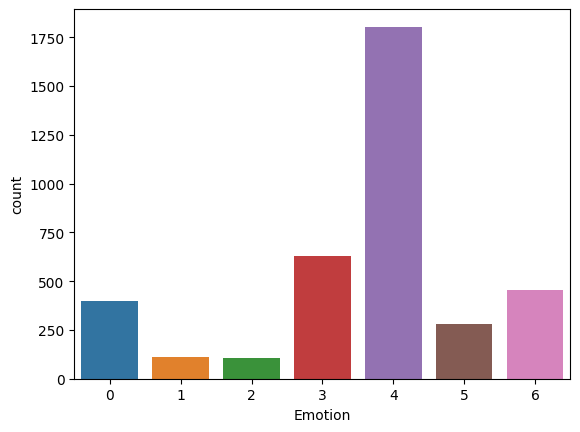

In [10]:
ax = sns.countplot(x=train_df['Emotion'], data=train_df)
print(train_df['Emotion'].value_counts())

Emotion
4    387
3    136
6     98
0     85
5     59
1     23
2     23
Name: count, dtype: int64


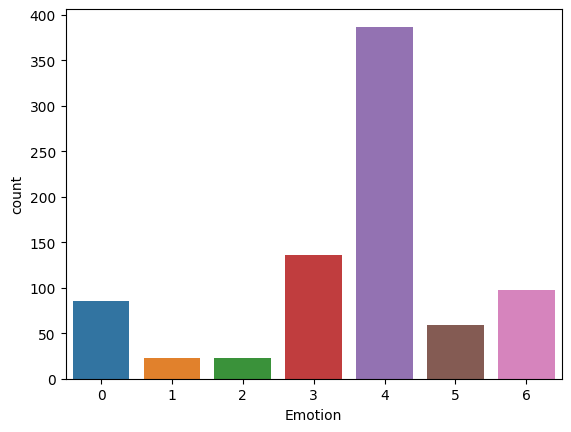

In [11]:
ax = sns.countplot(x=val_df['Emotion'], data=val_df)
print(val_df['Emotion'].value_counts())

Emotion
4    387
3    135
6     97
0     85
5     60
1     24
2     23
Name: count, dtype: int64


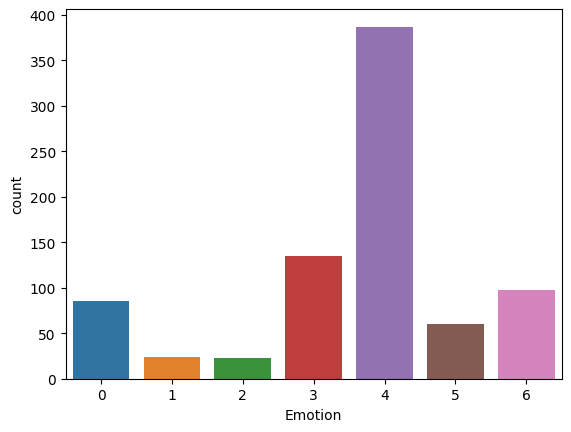

In [12]:
ax = sns.countplot(x=test_df['Emotion'], data=test_df)
print(test_df['Emotion'].value_counts())

> Observation: high class imbalance observed in dataset

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3784 entries, 4705 to 2634
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        3784 non-null   int64 
 1   Utterance     3784 non-null   object
 2   Speaker       3784 non-null   object
 3   Emotion       3784 non-null   int64 
 4   Sentiment     3784 non-null   object
 5   Dialogue_ID   3784 non-null   int64 
 6   Utterance_ID  3784 non-null   int64 
 7   Season        3784 non-null   int64 
 8   Episode       3784 non-null   int64 
 9   StartTime     3784 non-null   object
 10  EndTime       3784 non-null   object
dtypes: int64(6), object(5)
memory usage: 354.8+ KB


In [14]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 811 entries, 4031 to 189
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        811 non-null    int64 
 1   Utterance     811 non-null    object
 2   Speaker       811 non-null    object
 3   Emotion       811 non-null    int64 
 4   Sentiment     811 non-null    object
 5   Dialogue_ID   811 non-null    int64 
 6   Utterance_ID  811 non-null    int64 
 7   Season        811 non-null    int64 
 8   Episode       811 non-null    int64 
 9   StartTime     811 non-null    object
 10  EndTime       811 non-null    object
dtypes: int64(6), object(5)
memory usage: 76.0+ KB


In [15]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 811 entries, 3482 to 4600
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        811 non-null    int64 
 1   Utterance     811 non-null    object
 2   Speaker       811 non-null    object
 3   Emotion       811 non-null    int64 
 4   Sentiment     811 non-null    object
 5   Dialogue_ID   811 non-null    int64 
 6   Utterance_ID  811 non-null    int64 
 7   Season        811 non-null    int64 
 8   Episode       811 non-null    int64 
 9   StartTime     811 non-null    object
 10  EndTime       811 non-null    object
dtypes: int64(6), object(5)
memory usage: 76.0+ KB


# CV Module

## Define Custom Dataset

In [16]:
class EmotionDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        dia_id = self.df.iloc[idx]['Dialogue_ID']
        utt_id = self.df.iloc[idx]['Utterance_ID']
        img_name = f"result_dia{dia_id}_utt{utt_id}.png"
        label = self.df.iloc[idx]['Emotion']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

In [18]:
train_dataset = EmotionDataset('train.csv', '/kaggle/input/meld-output-faces/output_faces', transform=transform)
val_dataset = EmotionDataset('val.csv', '/kaggle/input/meld-output-faces/output_faces', transform=transform)

In [19]:
# Handling Class Imbalance with Weighted Sampling
labels = [label for _, label in train_dataset]
class_sample_counts = Counter(labels)
weights = [1.0 / class_sample_counts[label] for label in labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

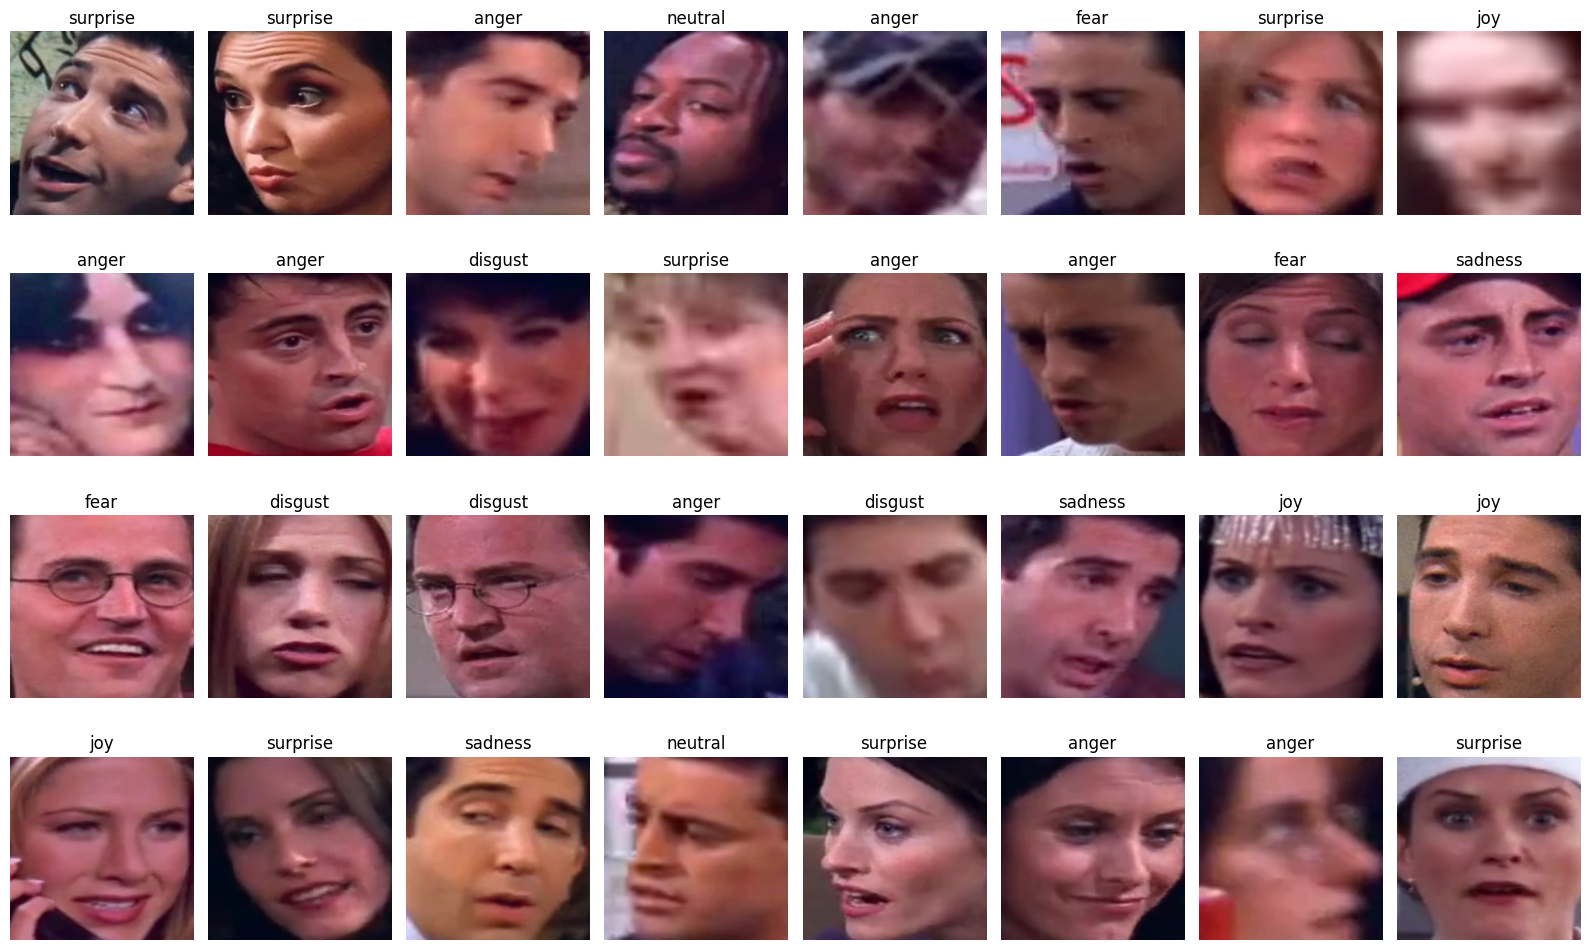

In [20]:
# Get a batch of training data
images, labels = next(iter(train_loader))
labels = label_encoder.inverse_transform(labels)
# Parameters for grid
nrow = 8
batch_size = images.size(0)
ncol = nrow
nrows = (batch_size + ncol - 1) // ncol  # Number of rows needed

fig, axes = plt.subplots(nrows, ncol, figsize=(ncol*2, nrows*2.5))

# Flatten axes array for easy indexing (in case of multiple rows)
axes = axes.flatten()

for i in range(batch_size):
    img = images[i]
    label = labels[i]  # or map to label name here
    
    # Convert tensor image to numpy
    npimg = img.numpy()
    
    # Transpose from (C, H, W) to (H, W, C)
    npimg = np.transpose(npimg, (1, 2, 0))
    
    # Since images are probably normalized, unnormalize if needed or just clip
    npimg = (npimg - npimg.min()) / (npimg.max() - npimg.min())
    
    axes[i].imshow(npimg)
    axes[i].set_title(str(label))
    axes[i].axis('off')

# Hide any leftover axes if batch_size < nrow*ncol
for j in range(batch_size, nrows * ncol):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

> Observation: since image dataset was extracted from videos also using ML, some images will be seemingly mislabeled from the get-go

## Define Model

In [21]:
# Attempt to define custom model

class VGG19Classifier(nn.Module):
    def __init__(self, num_classes=7):  # e.g., 7 for MELD emotions
        super(VGG19Classifier, self).__init__()

        self.features = nn.Sequential(
            # Block 1: 2x64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 2x128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 4x256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: 4x512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5: 4x512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Helper Functions

In [22]:
# Calculate class weights as experiment
class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_df['Emotion']),
                                     y=train_df['Emotion'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [23]:
# Experimental loss function
class FocalLoss(nn.Module):
    """
    Focal Loss, as described in https://arxiv.org/abs/1708.02002
    Args:
      gamma (float): focusing parameter (>=0).  gamma=0 is equivalent to CE.
      alpha (Tensor or float, optional): weight balancing factor in [0,1] or per-class list.
      reduction (str): 'mean' | 'sum' | 'none'
    """
    def __init__(self, gamma: float = 2.0, alpha=None, reduction: str = "mean"):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction

        if alpha is None:
            self.alpha = None
        elif isinstance(alpha, (float, int)):
            # binary case: alpha is weight for class 1
            self.alpha = torch.tensor([1 - alpha, alpha], dtype=torch.float)
        elif isinstance(alpha, (list, torch.Tensor)):
            # multi-class case: list of per-class weights
            self.alpha = torch.tensor(alpha, dtype=torch.float)
        else:
            raise ValueError("Invalid alpha value")

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor):
        # inputs: (N, C) raw logits
        # targets: (N,) with class indices 0...C-1
        logpt = -F.cross_entropy(inputs, targets, reduction="none",
                                 weight=self.alpha.to(inputs.device) if self.alpha is not None else None)
        pt = torch.exp(logpt)

        loss = -((1 - pt) ** self.gamma) * logpt

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:  # "none"
            return loss

## Training and Eval Loop

In [24]:
def train(model, train_loader, val_loader, num_epochs, device, lr=1e-4):
    model.to(device)
    #criterion = nn.CrossEntropyLoss(weight=class_weights)
    #criterion = FocalLoss(gamma=2.0, alpha=class_weights, reduction="mean")
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    #model.classifier.apply(init_weights)

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()

            loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

        val_acc, val_loss = evaluate(model, val_loader, criterion, device)
        print(f"Val Acc: {val_acc:.2f}%, Val Loss: {val_loss:.4f}")
        _, preds = torch.max(outputs, 1)
        #print("Sample predictions:", preds[:20])
        #print("Unique preds:", torch.unique(preds))

In [25]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total, correct, val_loss = 0, 0, 0.0
    best_val_acc = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_loss += loss.item()

    acc = 100.0 * correct / total
    avg_loss = val_loss / len(loader)
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), 'resnet_emotion_best.pth')
    return acc, avg_loss

In [26]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)

#from facenet_pytorch import InceptionResnetV1
#model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=7)

train(model, train_loader, val_loader, num_epochs=15, device=device, lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]
Epoch 1/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.69it/s, acc=51.4, loss=1.27] 


Val Acc: 20.72%, Val Loss: 1.9486


Epoch 2/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.78it/s, acc=79.8, loss=0.536]


Val Acc: 27.99%, Val Loss: 1.9376


Epoch 3/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.49it/s, acc=89.1, loss=0.663]


Val Acc: 35.64%, Val Loss: 1.8881


Epoch 4/15 [Train]: 100%|██████████| 119/119 [00:10<00:00, 11.46it/s, acc=94.5, loss=0.741]


Val Acc: 37.11%, Val Loss: 1.9318


Epoch 5/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 13.17it/s, acc=96.9, loss=0.568]


Val Acc: 37.98%, Val Loss: 1.9642


Epoch 6/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.93it/s, acc=97.5, loss=0.769]


Val Acc: 37.24%, Val Loss: 1.9482


Epoch 7/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.10it/s, acc=98.5, loss=0.718]


Val Acc: 39.33%, Val Loss: 1.9890


Epoch 8/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.40it/s, acc=98.9, loss=0.511]


Val Acc: 41.18%, Val Loss: 1.9382


Epoch 9/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.32it/s, acc=99.4, loss=0.509]


Val Acc: 40.20%, Val Loss: 1.9140


Epoch 10/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.44it/s, acc=99.6, loss=0.505]


Val Acc: 41.43%, Val Loss: 1.9556


Epoch 11/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.89it/s, acc=99.4, loss=0.482]


Val Acc: 42.91%, Val Loss: 1.9801


Epoch 12/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.24it/s, acc=99.8, loss=0.789]


Val Acc: 40.20%, Val Loss: 1.8981


Epoch 13/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.30it/s, acc=99.8, loss=0.537]


Val Acc: 42.42%, Val Loss: 1.8772


Epoch 14/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.83it/s, acc=99.9, loss=0.531]


Val Acc: 40.44%, Val Loss: 1.8883


Epoch 15/15 [Train]: 100%|██████████| 119/119 [00:09<00:00, 12.48it/s, acc=99.8, loss=0.622]


Val Acc: 42.05%, Val Loss: 1.9016


In [27]:
test_dataset = EmotionDataset('test.csv', '/kaggle/input/meld-output-faces/output_faces', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

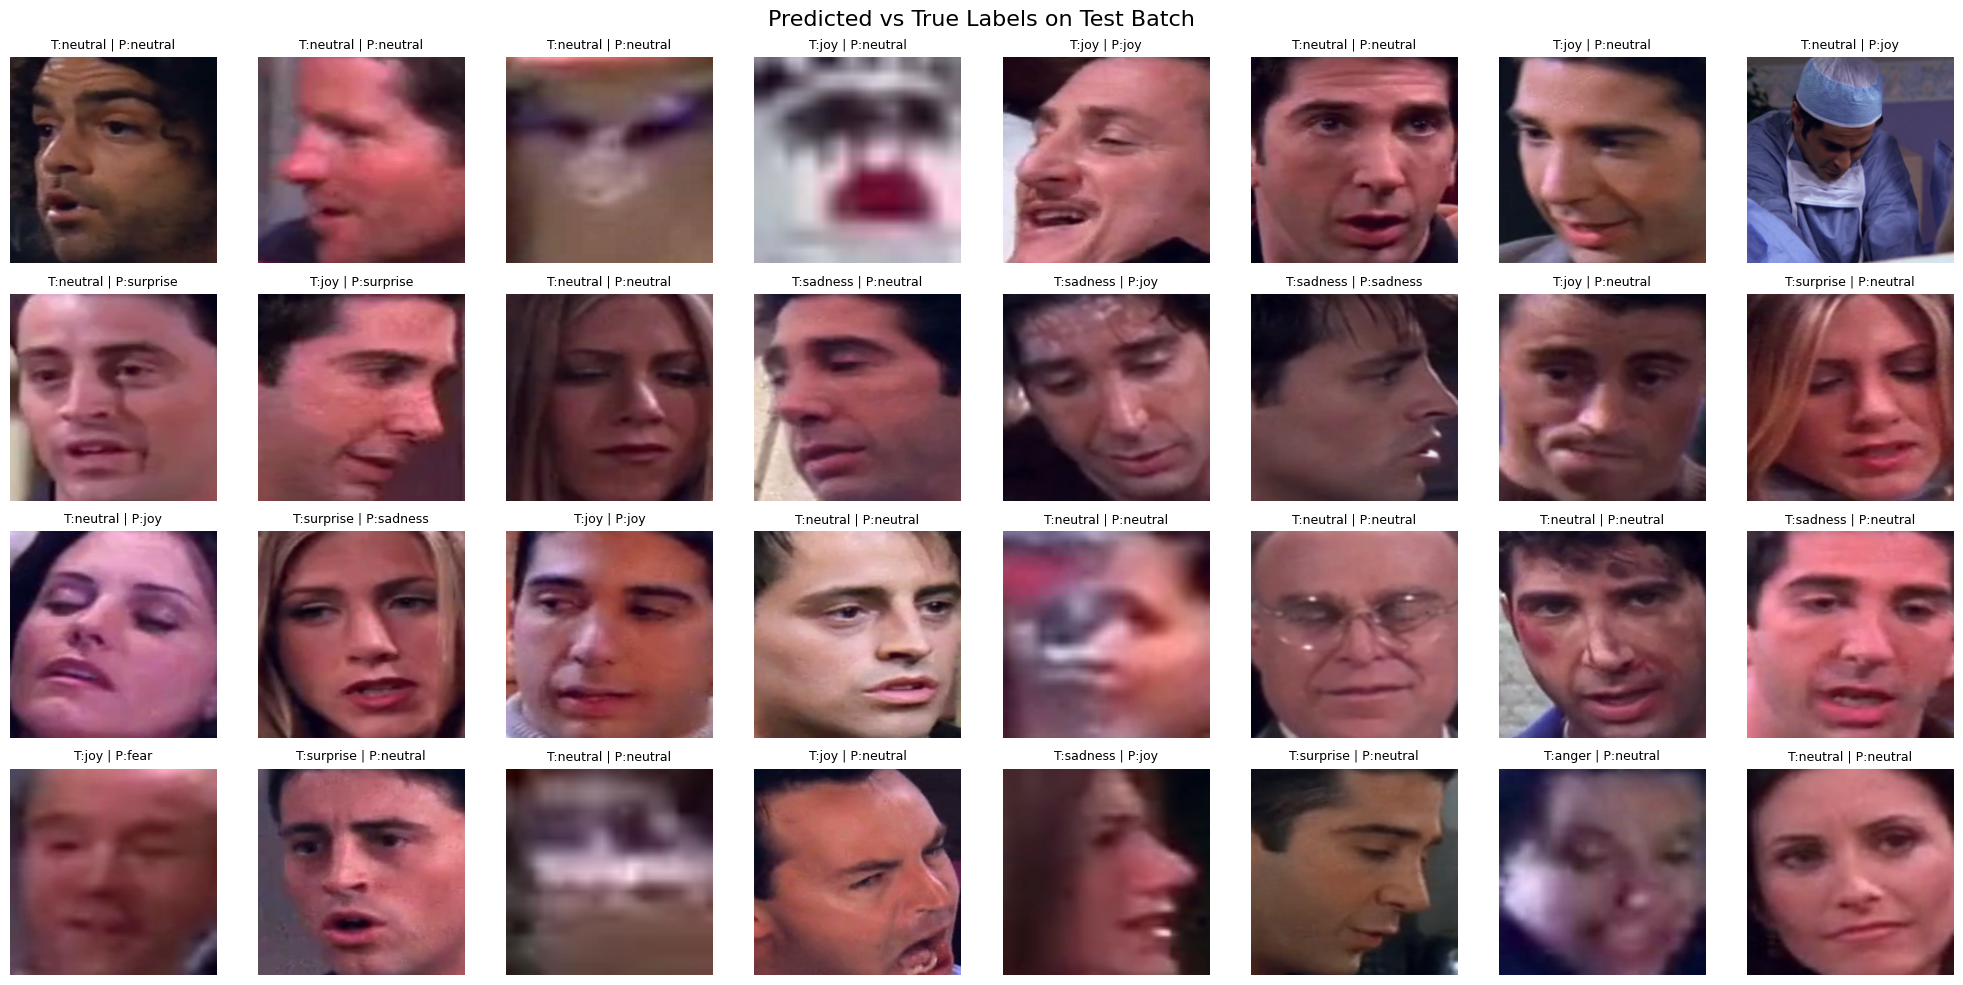

In [28]:
# Set model to evaluation mode
model.eval()

# Get a batch of test data
images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

# Run inference
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(1)

# Move everything to CPU for plotting
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

# Optional: decode labels using a LabelEncoder
labels = label_encoder.inverse_transform(labels)
preds = label_encoder.inverse_transform(preds)

# Plot images with true and predicted labels
plt.figure(figsize=(20, 10))
for i in range(32):
    plt.subplot(4, 8, i+1)
    img = images[i].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"T:{labels[i]} | P:{preds[i]}", fontsize=9)

plt.suptitle("Predicted vs True Labels on Test Batch", fontsize=16)
plt.tight_layout()
plt.show()